In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [4]:
def print_eda(data_path):
    files_to_analyze = [
        ("listens", data_path / "listens" / "listens.parquet"),
        ("likes", data_path / "likes" / "likes.parquet"),
        ("dislikes", data_path / "dislikes" / "dislikes.parquet"),
        ("unlikes", data_path / "unlikes" / "unlikes.parquet"),
        ("undislikes", data_path / "undislikes" / "undislikes.parquet"),
        ("multi_event", data_path / "multi_event" / "multi_event.parquet")
    ]

    print("\n" + "=" * 80)
    print("БАЗОВАЯ СТАТИСТИКА:")
    print("=" * 80)

    all_stats = []
    for name, file_path in files_to_analyze:
        if file_path.exists():
            print(f"\nФайл: {name}")
            
            # lazy API
            df = pl.scan_parquet(file_path)
            
            # базовая статистика статистику
            stats = df.select([
                pl.n_unique("uid").alias("unique_users"),
                pl.n_unique("item_id").alias("unique_tracks"),
                pl.min("timestamp").alias("min_timestamp"),
                pl.max("timestamp").alias("max_timestamp"),
                pl.count().alias("total_events")
            ]).collect()
            
            stats = stats.with_columns(pl.lit(name).alias("file_name"))
            all_stats.append(stats)
            
            print(f"  Уникальных пользователей: {stats['unique_users'][0]:,}")
            print(f"  Уникальных треков: {stats['unique_tracks'][0]:,}")
            print(f"  Минимальный timestamp: {stats['min_timestamp'][0]}")
            print(f"  Максимальный timestamp: {stats['max_timestamp'][0]}")
            print(f"  Продолжительность: ~{(stats['max_timestamp'][0] - stats['min_timestamp'][0]) / (24 * 60 * 60):.1f} дней")
            print(f"  Всего событий: {stats['total_events'][0]:,}")

    # сводная таблица
    if all_stats:
        summary_df = pl.concat(all_stats)
        print("\n" + "=" * 80)
        print("СВОДНАЯ ТАБЛИЦА:")
        print("=" * 80)
        print(summary_df.select(["file_name", "unique_users", "unique_tracks", "total_events"]))


    print("\n" + "=" * 80)
    print("РАСПРЕДЕЛЕНИЕ ДЕЙСТВИЙ ПО ВРЕМЕНИ")
    print("=" * 80)

    multi_event_path = data_path / "multi_event" / "multi_event.parquet"
    if multi_event_path.exists():
        time_stats = pl.scan_parquet(multi_event_path).select([
            pl.min("timestamp").alias("min_ts"),
            pl.max("timestamp").alias("max_ts"),
            pl.count().alias("total_events")
        ]).collect()
        
        min_ts = time_stats["min_ts"][0]
        max_ts = time_stats["max_ts"][0]
        total_events = time_stats["total_events"][0]
        
        print(f"Диапазон времени: {min_ts} - {max_ts}")
        print(f"Продолжительность: {(max_ts - min_ts) / (24*60*60):.1f} дней")
        print(f"Всего событий: {total_events:,}")
        
        event_counts = (
            pl.scan_parquet(multi_event_path)
            .select(["event_type"])
            .collect(streaming=True)
            .group_by("event_type")
            .agg(pl.count().alias("count"))
            .sort("count", descending=True)
        )
        
        print("\nРаспределение типов событий:")
        print(event_counts)
        
        daily_counts = (
            pl.scan_parquet(multi_event_path)
            .select([
                ((pl.col("timestamp") - min_ts) / (24*60*60))
                .cast(pl.Float64)
                .alias("days_since_min")
            ])
            .collect(streaming=True)
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1 = axes[0]
        ax1.hist(daily_counts["days_since_min"].to_numpy(), bins=50, alpha=0.7)
        ax1.set_title('Распределение событий по времени')
        ax1.set_xlabel('Дни от начала наблюдений')
        ax1.set_ylabel('Количество событий')
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[1]
        event_counts_pd = event_counts.to_pandas()
        bars = ax2.bar(event_counts_pd['event_type'], event_counts_pd['count'])
        ax2.set_title('Количество событий по типам')
        ax2.set_ylabel('Количество')
        ax2.tick_params(axis='x', rotation=45)
        
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()

    print("\n" + "=" * 80)
    print("РАСПРЕДЕЛЕНИЕ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ")
    print("=" * 80)

    if multi_event_path.exists():
        user_activity = (
            pl.scan_parquet(multi_event_path)
            .group_by("uid")
            .agg(pl.count().alias("event_count"))
            .sort("event_count", descending=True)
            .collect(streaming=True)
        )
        
        total_users = len(user_activity)
        print(f"Всего уникальных пользователей: {total_users:,}")
        print(f"Максимальная активность: {user_activity['event_count'][0]:,} событий")
        print(f"Минимальная активность: {user_activity['event_count'][-1]:,} событий")
        print(f"Медианная активность: {user_activity['event_count'].median():,.0f} событий")
        
        print("\nКвантили распределения активности:")
        quantile_values = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
        for q in quantile_values:
            value = user_activity["event_count"].quantile(q)
            print(f"  {q*100:.0f}% пользователей имеют ≤ {value:,.0f} событий")
        
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
            
        ax1 = axes
        activity_counts = user_activity["event_count"].to_numpy()

        ax1.hist(activity_counts, bins=50, alpha=0.7, edgecolor='black')
        ax1.set_title('Распределение активности пользователей')
        ax1.set_xlabel('Количество событий на пользователя')
        ax1.set_ylabel('Количество пользователей')
        ax1.grid(True, alpha=0.3)

        colors = ['r', 'g', 'b', 'orange', 'purple', 'brown']
        for q, color in zip(quantile_values, colors):
            value = user_activity["event_count"].quantile(q)
            ax1.axvline(x=value, color=color, linestyle='--', alpha=0.7, 
                    label=f'{q*100:.0f}%: {value:,.0f}')

        ax1.legend(fontsize=8)
            
        plt.tight_layout()
        plt.show()

    print("\n" + "=" * 80)
    print("РАСПРЕДЕЛЕНИЕ УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВРЕМЕНИ (НАКОПИТЕЛЬНО)")
    print("=" * 80)

    if multi_event_path.exists():
        
        df_multi = pl.scan_parquet(multi_event_path)
        
        min_ts = df_multi.select(pl.min("timestamp")).collect()["timestamp"][0]
        
        df_users_first_day = (
            df_multi
            .with_columns([
                ((pl.col("timestamp") - min_ts) / (24 * 60 * 60)).cast(pl.Int32).alias("day")
            ])
            .group_by("uid")
            .agg(pl.min("day").alias("first_day"))
            .collect(streaming=True)
        )
        
        first_day_distribution = (
            df_users_first_day.lazy()
            .group_by("first_day")
            .agg(pl.count().alias("new_users"))
            .sort("first_day")
            .collect()
        )
        
        cumulative_users = first_day_distribution.with_columns([
            pl.col("new_users").cum_sum().alias("cumulative_unique_users")
        ])
        
        max_day = cumulative_users["first_day"].max()
        total_users = cumulative_users["cumulative_unique_users"][-1]
        
        print(f"Всего уникальных пользователей: {total_users:,}")
        print(f"В среднем новых пользователей в день: {cumulative_users['new_users'].mean():,.0f}")
        
        plt.figure(figsize=(12, 6))
        
        plt.plot(cumulative_users["first_day"], cumulative_users["cumulative_unique_users"], 
                linewidth=2, color='blue', marker='o', markersize=3)
        
        plt.title('Накопительное количество уникальных пользователей по дням')
        plt.xlabel('Дни от начала наблюдений')
        plt.ylabel('Количество уникальных пользователей')
        plt.grid(True, alpha=0.3)
        
        plt.annotate(f'Всего: {total_users:,}',
                    xy=(max_day, total_users),
                    xytext=(max_day * 0.8, total_users * 0.8),
                    arrowprops=dict(arrowstyle='->'),
                    fontsize=10)
        
        plt.tight_layout()
        plt.show()

    print("\n" + "=" * 80)
    print("КУМУЛЯТИВНАЯ ДОЛЯ ПРОСЛУШИВАНИЙ ПО ПОЛЬЗОВАТЕЛЯМ")
    print("=" * 80)

    listens_path = data_path / "listens" / "listens.parquet"
    if listens_path.exists():
        user_listens = (
            pl.scan_parquet(listens_path)
            .group_by("uid")
            .agg(pl.count().alias("listen_count"))
            .sort("listen_count", descending=True)
            .collect(streaming=True)
        )
        
        total_listens = user_listens["listen_count"].sum()
        total_users = len(user_listens)
        
        print(f"Всего прослушиваний: {total_listens:,}")
        print(f"Всего уникальных пользователей с прослушиваниями: {total_users:,}")
        print(f"Среднее количество прослушиваний на пользователя: {total_listens/total_users:,.1f}")
        
        sorted_counts = user_listens["listen_count"].to_numpy()
        cumulative_sum = np.cumsum(sorted_counts)
        cumulative_ratio = cumulative_sum / total_listens
        
        thresholds = [0.5, 0.8, 0.9, 0.95, 0.99]
        print("\nАнализ концентрации активности:")
        for threshold in thresholds:
            idx = np.where(cumulative_ratio >= threshold)[0]
            if len(idx) > 0:
                users_needed = idx[0] + 1
                user_percentage = (users_needed / total_users) * 100
                print(f"  {threshold*100:.0f}% прослушиваний создают {users_needed:,} пользователей "
                    f"({user_percentage:.2f}% всех пользователей)")
        
        played_stats_sample = (
            pl.scan_parquet(listens_path)
            .select("played_ratio_pct")
            .filter(pl.col("played_ratio_pct").is_not_null())
            .limit(100000)
            .collect()
            .describe()
        )
        print("\nСтатистика по played_ratio_pct (выборка 100K записей):")
        print(played_stats_sample.select(["statistic", "played_ratio_pct"]))

        
        fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
        
        user_percentages = np.arange(len(cumulative_ratio)) / len(cumulative_ratio) * 100
        ax1.plot(user_percentages, cumulative_ratio * 100, linewidth=2)
        
        ax1.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Линия равенства')
        
        colors = ['r', 'g', 'b', 'orange', 'purple']
        for i, threshold in enumerate(thresholds):
            if i < len(colors):
                idx = np.where(cumulative_ratio >= threshold)[0]
                if len(idx) > 0:
                    users_needed = idx[0]
                    user_percentage = (users_needed / len(cumulative_ratio)) * 100
                    ax1.axvline(x=user_percentage, color=colors[i], linestyle='--', alpha=0.7, 
                            label=f'{threshold*100:.0f}% listens - {user_percentage:.1f}% users')
                    ax1.axhline(y=threshold*100, color=colors[i], linestyle='--', alpha=0.7)
        
        # аналог кривой Лоренца
        ax1.set_title('Кумулятивная доля прослушиваний')
        ax1.set_xlabel('Процент пользователей (отсортированы по активности)')
        ax1.set_ylabel('Процент прослушиваний')
        ax1.legend(loc='lower right', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    print("\n" + "=" * 80)
    print("ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
    print("=" * 80)

    for name, file_path in files_to_analyze:
        if file_path.exists():
            print(f"\nПроверка {name}:")
            df_check = pl.scan_parquet(file_path)
            
            null_stats = df_check.select([
                pl.col("uid").is_null().sum().alias("null_uid"),
                pl.col("item_id").is_null().sum().alias("null_item_id"),
                pl.col("timestamp").is_null().sum().alias("null_timestamp")
            ]).collect()
            
            print(f"  Пропущено uid: {null_stats['null_uid'][0]:,}")
            print(f"  Пропущено item_id: {null_stats['null_item_id'][0]:,}")
            print(f"  Пропущено timestamp: {null_stats['null_timestamp'][0]:,}")


БАЗОВАЯ СТАТИСТИКА:

Файл: listens
  Уникальных пользователей: 9,238
  Уникальных треков: 877,168
  Минимальный timestamp: 0
  Максимальный timestamp: 26000000
  Продолжительность: ~300.9 дней
  Всего событий: 46,467,212

Файл: likes
  Уникальных пользователей: 8,283
  Уникальных треков: 181,304
  Минимальный timestamp: 80
  Максимальный timestamp: 25999970
  Продолжительность: ~300.9 дней
  Всего событий: 881,456

Файл: dislikes
  Уникальных пользователей: 5,951
  Уникальных треков: 53,413
  Минимальный timestamp: 75
  Максимальный timestamp: 25999945
  Продолжительность: ~300.9 дней
  Всего событий: 107,776

Файл: unlikes
  Уникальных пользователей: 6,406
  Уникальных треков: 117,953
  Минимальный timestamp: 250
  Максимальный timestamp: 25999945
  Продолжительность: ~300.9 дней
  Всего событий: 312,972

Файл: undislikes
  Уникальных пользователей: 2,911
  Уникальных треков: 15,399
  Минимальный timestamp: 15950
  Максимальный timestamp: 25993175
  Продолжительность: ~300.7 дней
  В

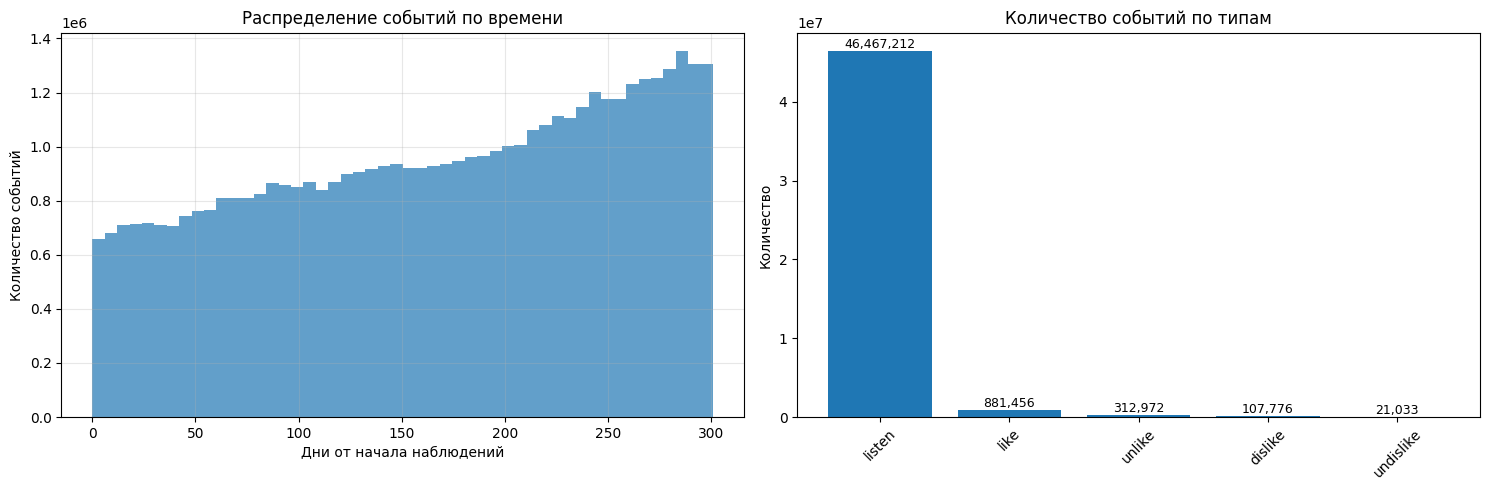


РАСПРЕДЕЛЕНИЕ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ
Всего уникальных пользователей: 10,000
Максимальная активность: 27,699 событий
Минимальная активность: 11 событий
Медианная активность: 2,654 событий

Квантили распределения активности:
  25% пользователей имеют ≤ 687 событий
  50% пользователей имеют ≤ 2,655 событий
  75% пользователей имеют ≤ 6,856 событий
  90% пользователей имеют ≤ 12,865 событий
  95% пользователей имеют ≤ 17,091 событий
  99% пользователей имеют ≤ 24,140 событий


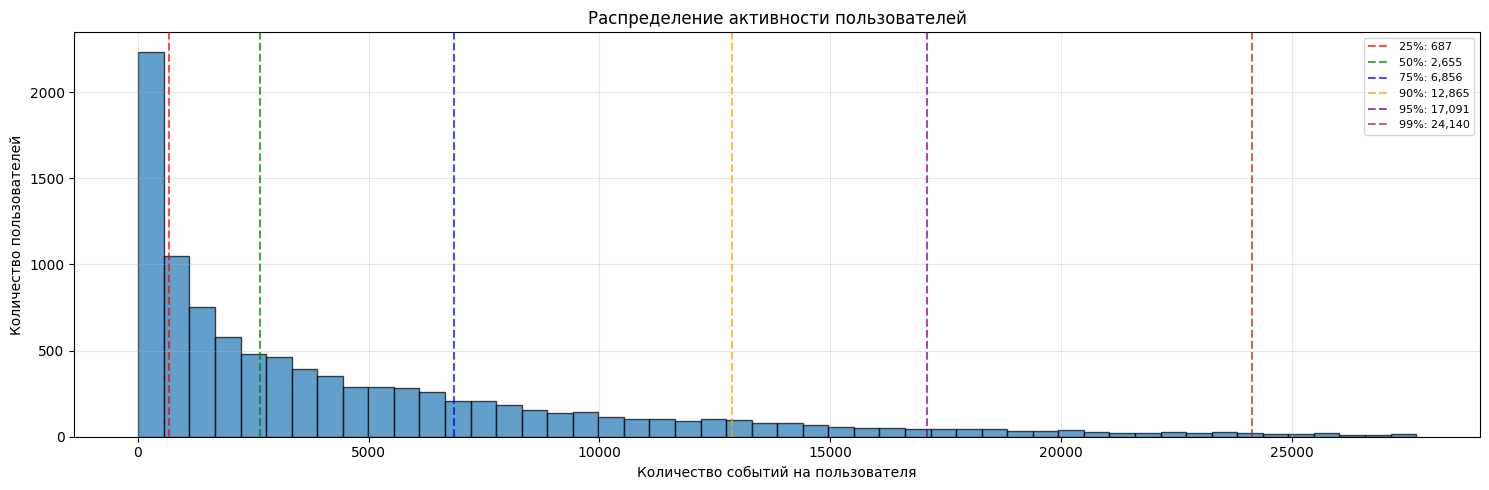


РАСПРЕДЕЛЕНИЕ УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВРЕМЕНИ (НАКОПИТЕЛЬНО)
Всего уникальных пользователей: 10,000
В среднем новых пользователей в день: 35


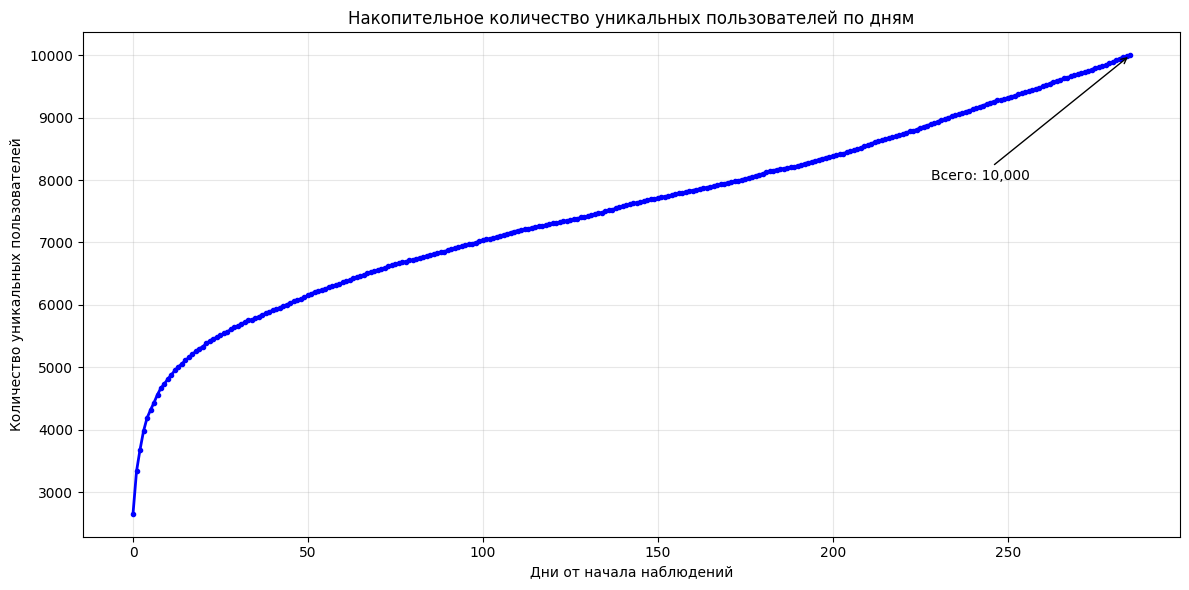


КУМУЛЯТИВНАЯ ДОЛЯ ПРОСЛУШИВАНИЙ ПО ПОЛЬЗОВАТЕЛЯМ
Всего прослушиваний: 46,467,212
Всего уникальных пользователей с прослушиваниями: 9,238
Среднее количество прослушиваний на пользователя: 5,030.0

Анализ концентрации активности:
  50% прослушиваний создают 1,497 пользователей (16.20% всех пользователей)
  80% прослушиваний создают 3,526 пользователей (38.17% всех пользователей)
  90% прослушиваний создают 4,800 пользователей (51.96% всех пользователей)
  95% прослушиваний создают 5,839 пользователей (63.21% всех пользователей)
  99% прослушиваний создают 7,500 пользователей (81.19% всех пользователей)

Статистика по played_ratio_pct (выборка 100K записей):
shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ played_ratio_pct │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 100000.0         │
│ null_count ┆ 0.0              │
│ mean       ┆ 73.37638         │
│ std        ┆ 40.31717         │
│ min        ┆ 

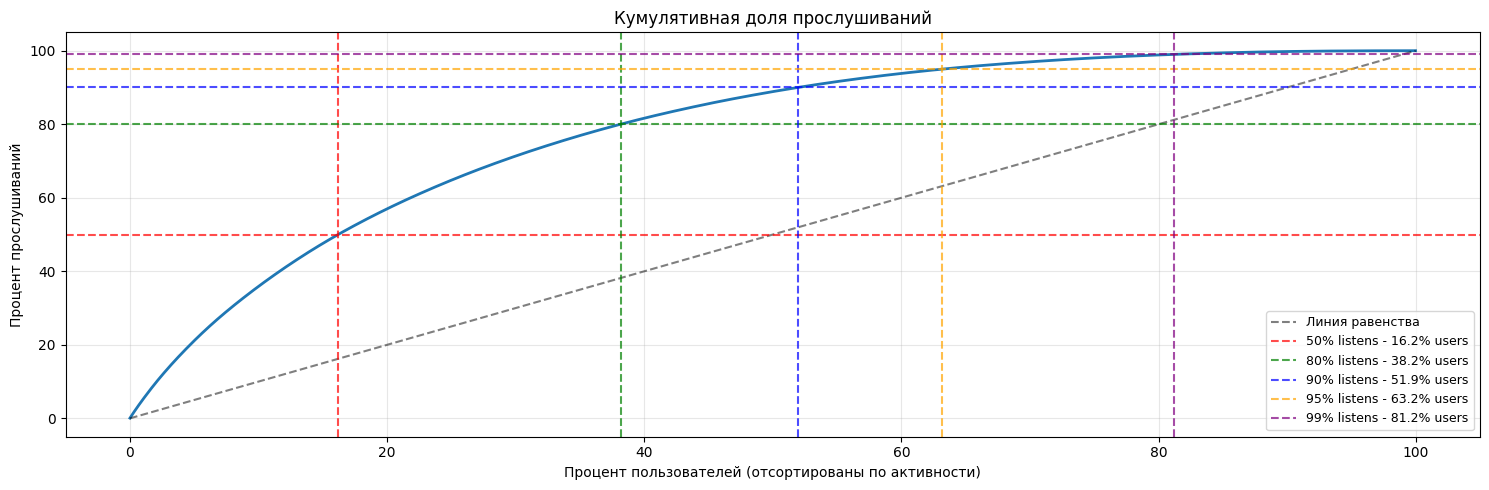


ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Проверка listens:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка likes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка dislikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка unlikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка undislikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка multi_event:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0


In [9]:
data_path = Path("data/flat/50m")
print_eda(data_path)


БАЗОВАЯ СТАТИСТИКА:

Файл: listens
  Уникальных пользователей: 92,085
  Уникальных треков: 2,796,658
  Минимальный timestamp: 0
  Максимальный timestamp: 26000000
  Продолжительность: ~300.9 дней
  Всего событий: 466,512,103

Файл: likes
  Уникальных пользователей: 82,788
  Уникальных треков: 638,230
  Минимальный timestamp: 35
  Максимальный timestamp: 25999995
  Продолжительность: ~300.9 дней
  Всего событий: 9,033,960

Файл: dislikes
  Уникальных пользователей: 59,381
  Уникальных треков: 232,382
  Минимальный timestamp: 65
  Максимальный timestamp: 25999995
  Продолжительность: ~300.9 дней
  Всего событий: 1,128,113

Файл: unlikes
  Уникальных пользователей: 63,867
  Уникальных треков: 479,679
  Минимальный timestamp: 155
  Максимальный timestamp: 25999990
  Продолжительность: ~300.9 дней
  Всего событий: 3,309,936

Файл: undislikes
  Уникальных пользователей: 28,936
  Уникальных треков: 94,036
  Минимальный timestamp: 1090
  Максимальный timestamp: 25999655
  Продолжительность: ~

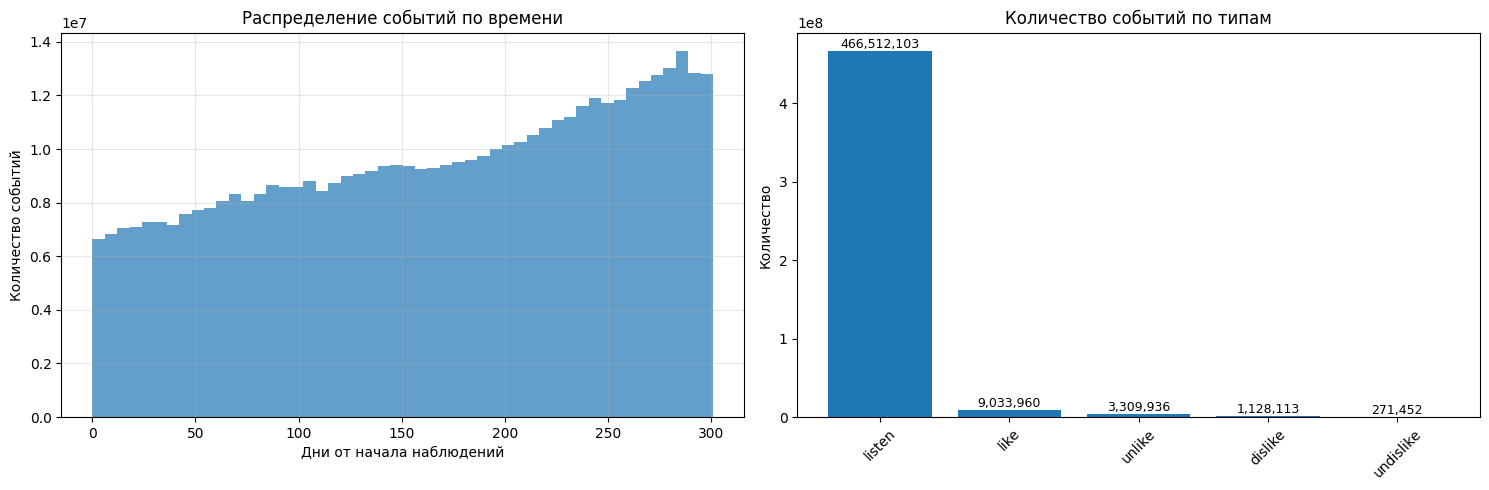


РАСПРЕДЕЛЕНИЕ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ
Всего уникальных пользователей: 100,000
Максимальная активность: 27,736 событий
Минимальная активность: 11 событий
Медианная активность: 2,705 событий

Квантили распределения активности:
  25% пользователей имеют ≤ 709 событий
  50% пользователей имеют ≤ 2,705 событий
  75% пользователей имеют ≤ 6,944 событий
  90% пользователей имеют ≤ 12,787 событий
  95% пользователей имеют ≤ 16,922 событий
  99% пользователей имеют ≤ 24,098 событий


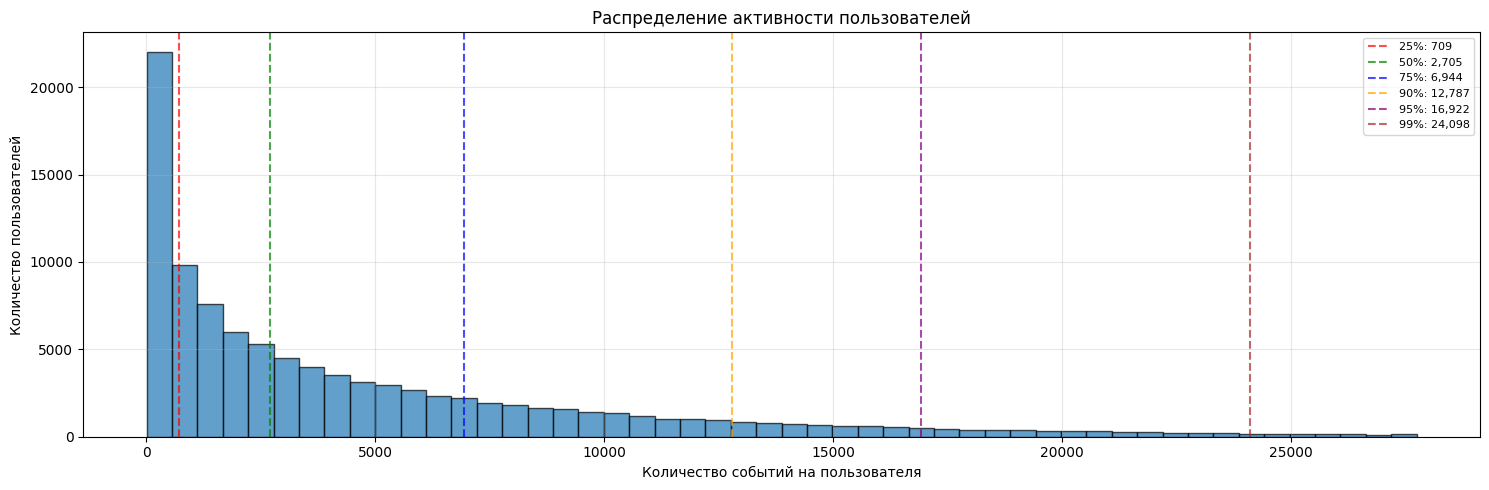


РАСПРЕДЕЛЕНИЕ УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВРЕМЕНИ (НАКОПИТЕЛЬНО)
Всего уникальных пользователей: 100,000
В среднем новых пользователей в день: 350


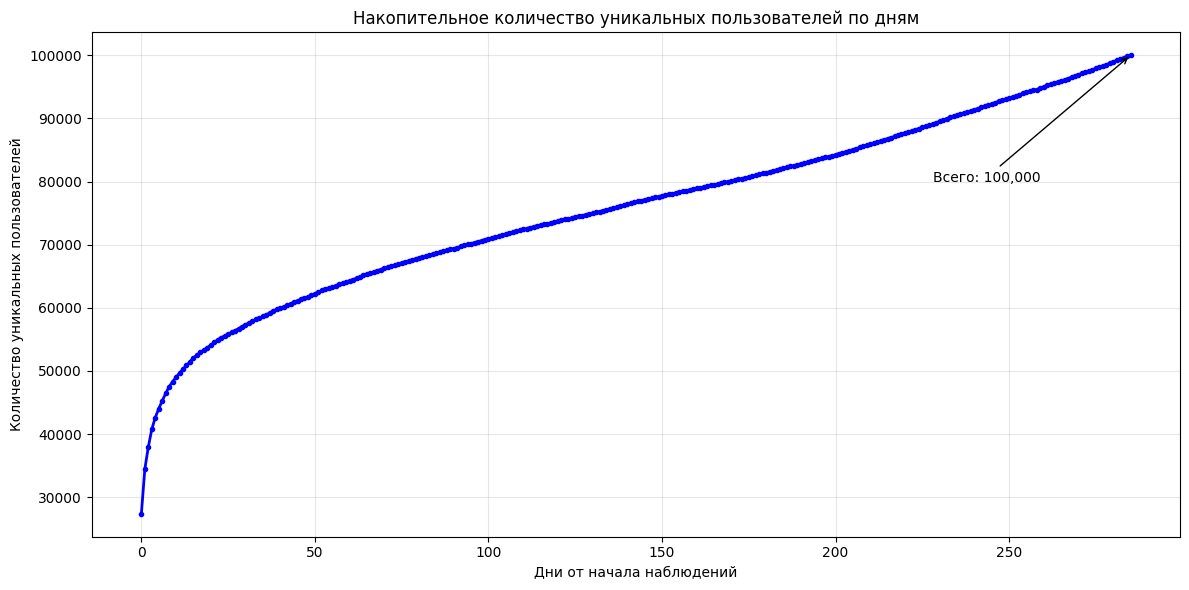


КУМУЛЯТИВНАЯ ДОЛЯ ПРОСЛУШИВАНИЙ ПО ПОЛЬЗОВАТЕЛЯМ
Всего прослушиваний: 466,512,103
Всего уникальных пользователей с прослушиваниями: 92,085
Среднее количество прослушиваний на пользователя: 5,066.1

Анализ концентрации активности:
  50% прослушиваний создают 15,215 пользователей (16.52% всех пользователей)
  80% прослушиваний создают 35,619 пользователей (38.68% всех пользователей)
  90% прослушиваний создают 48,456 пользователей (52.62% всех пользователей)
  95% прослушиваний создают 58,817 пользователей (63.87% всех пользователей)
  99% прослушиваний создают 74,866 пользователей (81.30% всех пользователей)

Статистика по played_ratio_pct (выборка 100K записей):
shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ played_ratio_pct │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 100000.0         │
│ null_count ┆ 0.0              │
│ mean       ┆ 66.95651         │
│ std        ┆ 43.666703        │
│ min   

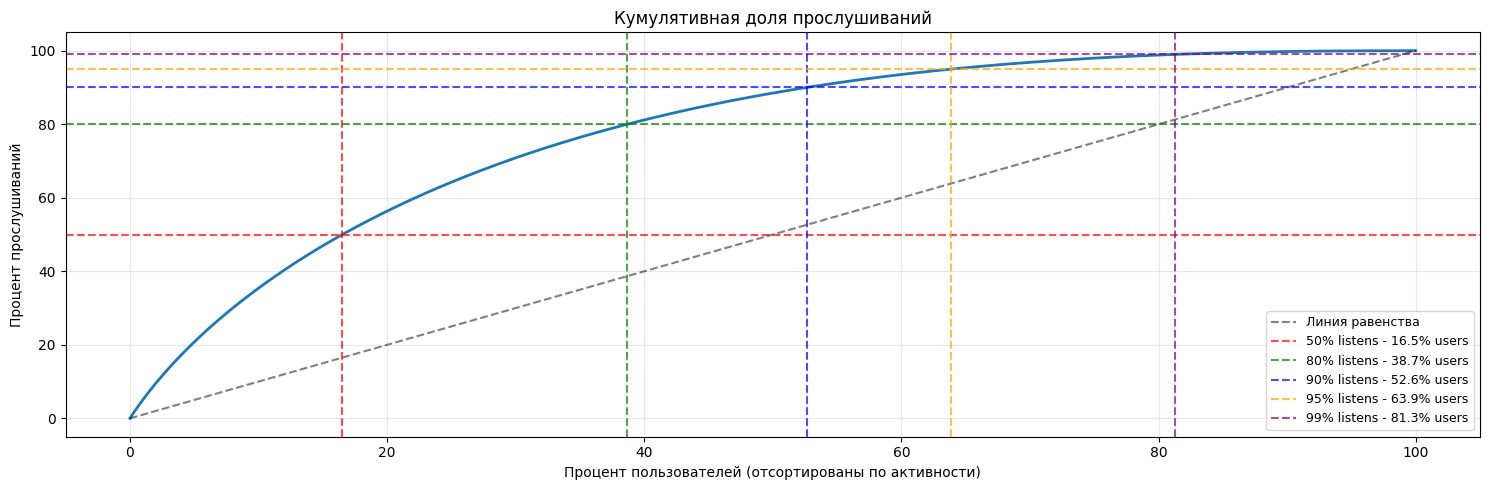


ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Проверка listens:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка likes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка dislikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка unlikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка undislikes:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0

Проверка multi_event:
  Пропущено uid: 0
  Пропущено item_id: 0
  Пропущено timestamp: 0


In [7]:
data_path = Path("data/flat/500m")
print_eda(data_path)